# EarthMIP Trial

**Installation**

* [apex](https://github.com/NVIDIA/apex#quick-start)

In [1]:
import autoroot
import datetime
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference
import matplotlib.pyplot as plt
from bayesevt._src.data.ics import LocalDataSource

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model

In [35]:
model_name = "fcnv2_sm" # "fcn" # 
model = f"e2mip://{model_name}"
device = "cuda:0"

In [36]:
time_loop  = get_model(
    model=model,
    device=device,
)

channel_names = time_loop.in_channel_names

## Initial Condition

In [27]:
FILE_PATHS = {
    "fcn": [
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcn_sl_20210801.grib",
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcn_pl_20210801.grib"
],
    "fcnv2_sm": [
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_sl_20210801.grib",
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_pl_20210801.grib"
]
}

In [28]:
file_paths = FILE_PATHS[model_name]
# initial condition
data_source = LocalDataSource(
    channel_names=channel_names,
    file_paths=file_paths
)
# initial condition
# data_source = cds.DataSource(time_loop.in_channel_names)

In [29]:
# starting timestep
t0 = datetime.datetime(2021,8,1)
# number of forecast steps
num_steps = 10 # 6h intervals

## Inference Loop

In [30]:
%%time
ds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source, 
    time=t0
)

CPU times: user 3.12 s, sys: 15.9 s, total: 19 s
Wall time: 20.4 s


In [31]:
ds.chunk()

<xarray.DataArray (time: 11, history: 1, channel: 26, lat: 720, lon: 1440)>
dask.array<xarray-<this-array>, shape=(11, 1, 26, 720, 1440), dtype=float32, chunksize=(11, 1, 26, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * channel  (channel) <U5 'u10m' 'v10m' 't2m' 'sp' ... 'v250' 'z250' 't250'
  * time     (time) datetime64[ns] 2021-08-01 ... 2021-08-03T12:00:00
Dimensions without coordinates: history

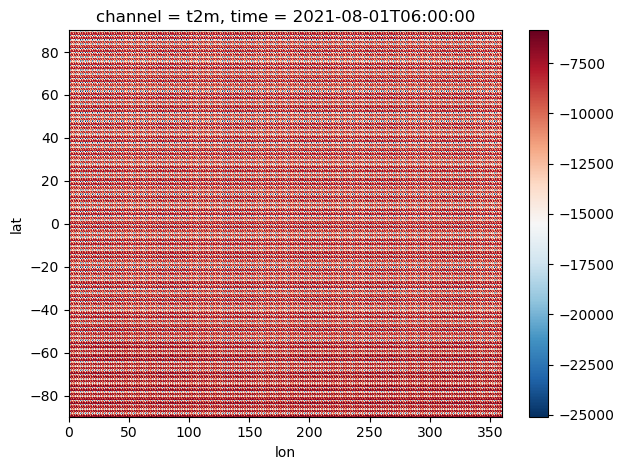

In [34]:
fig, ax = plt.subplots()
ds.sel(channel="t2m").isel(time=1).squeeze().plot.pcolormesh(ax=ax, cmap="RdBu_r")
plt.tight_layout()
plt.show()

In [33]:
from pathlib import Path

save_dir = Path("/pool/proyectos/CLINT/temp/sa4attrs/data/pred/earth2mip")
save_name = f"{model_name.replace('_','')}"
save_name += f"-{str(t0.date()).replace('-','')}"
save_name += ".nc"
save_name = save_name.replace('-','_')
save_dir = save_dir.joinpath(save_name)
save_dir

PosixPath('/pool/proyectos/CLINT/temp/sa4attrs/data/pred/earth2mip/fcn_20210801.nc')

In [ ]:
ds.to_netcdf()